# Practical 3
## A) To understand the Multi Layer Perceptron by manually training model on Minst dataset from scratch

#### The MNIST (Modified National Institute of Standards and Technology) dataset is used in machine learning and deep learning, particularly for image classification tasks. It consists of a large collection of grayscale images of handwritten digits (0-9). 

> The dataset comprises 70,000 images of handwritten digits. Each image is a 28x28 pixel grayscale image.
- **Structure:**
>**Training Set:** 60,000 images used to train machine learning models.
>
>**Test Set:** 10,000 images used to evaluate the performance of trained models.
- **Data Format:**
>**Images (Features):** Each image is represented as a 28x28 array of pixel values, typically ranging from 0 to 255 (representing grayscale intensity).
>
>**Labels (Targets):** Each image has a corresponding label indicating the digit it represents (0-9). 

## Software Used 
- Python (3.x)
- Jupyter-Lab
## Libraries Used
- JAX
- Matplotlib
- Tensorflow

### Necessary Imports

In [1]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from jax.nn import one_hot

### Iniating necessary variables for training Multi-Layer Perceptron

In [2]:
def init_params(key, l,L):
    params = []
    for i in range(l - 1):
        key, subkey = random.split(key)
        w = random.normal(subkey, (L[i], L[i + 1])) * jnp.sqrt(2.0 / L[i]) #for stable variance
        b = jnp.zeros((L[i + 1],))
        params.append((w, b))
    return params

###  Forward Propagation

In [3]:
def forward(params, x):
    """
    Forward pass through the MLP
    params: list of (w, b) for each layer
    x: input data, shape (batch_size, input_dim)
    """
    activations = x
    # Hidden layers
    for w, b in params[:-1]:
        z = jnp.dot(activations, w) + b   # linear
        activations = jax.nn.relu(z)      # non-linear (can use sigmoid/tanh instead)
    
    # Output layer (last one)
    w, b = params[-1]
    logits = jnp.dot(activations, w) + b
    probs = jax.nn.softmax(logits, axis=1)  # probabilities for classification
    
    return probs, logits

In [ ]:
'''def forward(params, x):
    a = x
    for i, (w, b) in enumerate(params):
        z = jnp.dot(a, w) + b
        # Hidden layers use sigmoid
        if i < len(params) - 1:
            a = jax.nn.sigmoid(z)
        else:
            # Last layer uses softmax (for multi-class classification)
            a = jax.nn.softmax(z, axis=1)
    return a'''

### Finding Accuracy

In [4]:
def accuracy(params, x, y_true):
    y_pred,logits = forward(params, x)
    preds = jnp.argmax(y_pred, axis=1)
    labels = jnp.argmax(y_true, axis=1)
    return jnp.mean(preds == labels)

### Loss Function

In [5]:
def loss_fn(params, X, Y):
    """
    Categorical Cross-Entropy Loss
    X : [batch_size, features]
    Y : [batch_size, num_classes] (one-hot encoded)
    """
    logits = forward(params, X)[0]   # output before softmax
    # Apply softmax
    probs = jax.nn.softmax(logits, axis=1)
    # Numerical stability: clip
    probs = jnp.clip(probs, 1e-9, 1.0)
    # Compute CCE
    loss = -jnp.mean(jnp.sum(Y * jnp.log(probs), axis=1))
    return loss

### Training MLP Model

In [6]:
def MLP_Training(params, x_train, y_train, x_test, y_test, epochs=100, batch_size=32, lr=0.01):
    historys = {"loss": [], "accuracy": []}
    n_samples = x_train.shape[0]
    history = []
    for epoch in range(epochs):
        # Shuffle dataset at the start of each epoch
        idx = jax.random.permutation(jax.random.PRNGKey(epoch), n_samples)
        x_train, y_train = x_train[idx], y_train[idx]

        # Loop over batches
        for i in range(0, n_samples, batch_size):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward + Backward + Update
            loss, grads = jax.value_and_grad(loss_fn)(params, x_batch, y_batch)

            params = [(w - lr * dw, b - lr * db) 
                    for (w, b), (dw, db) in zip(params, grads)]

        # Track loss/accuracy after epoch
        acc = accuracy(params, x_test, y_test)
        historys["loss"].append(loss)
        historys["accuracy"].append(acc)
        history.append({"epoch": epoch, "loss": float(loss), "accuracy": float(acc),"weight":params[0][0],"bias":params[0][1]})

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    return params, history

### Generate graph for plotting Loss and Accuracy evolution over Epochs

In [7]:
def plot_loss_accuracy(history):
    if not history:
        print("No training history to plot.")
        return
    
    # Support both list of dicts and simple list of floats
    if isinstance(history[0], dict):
        # Extract losses and epochs if present
        losses = jnp.array([float(h.get('loss', jnp.nan)) for h in history])
        epochs = jnp.array([h.get('epoch', i) for i, h in enumerate(history)])
        accuracies   = jnp.array([float(h.get('accuracy', jnp.nan)) for h in history])
    else:
        losses = jnp.array(history)
        epochs = jnp.arange(len(losses))
        losses = jnp.full_like(losses, jnp.nan)   # No MSE in simple case
        accuracies = jnp.full_like(losses, jnp.nan)   # No accuracy in simple case
        
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, losses, marker='o', label="Loss")
    plt.plot(epochs, accuracies, marker='s', label="Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Generate graph for plotting Weight and Bias evolution over Epochs

In [9]:
def plot_params_evolution(history):
    if not history:
        print("No training history to plot parameters.")
        return

    epochs = [h["epoch"] for h in history]
    # history[0]["weights"] and history[0]["biases"] exist and are lists of arrays
    num_weight_layers = len(history[0]["weight"])
    num_bias_layers = len(history[0]["bias"])

    # Plot Weights
    for i in range(num_weight_layers):
        plt.figure(figsize=(10, 6))
        # Transpose weights for easier plotting of individual weights
        layer_weights = jnp.stack([h["weight"][i].flatten() for h in history])
        for j in range(layer_weights.shape[1]):
            plt.plot(epochs, layer_weights[:, j], label=f'Weight {j+1}')
        plt.xlabel("Epochs")
        plt.ylabel("Weight Value")
        plt.title(f"Evolution of Weights in Layer {i+1}")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot Biases
    for i in range(num_bias_layers):
        plt.figure(figsize=(10, 6))
        layer_biases = jnp.stack([h["bias"][i].flatten() for h in history])
        for j in range(layer_biases.shape[1]):
             plt.plot(epochs, layer_biases[:, j], label=f'Bias {j+1}')
        plt.xlabel("Epochs")
        plt.ylabel("Bias Value")
        plt.title(f"Evolution of Biases in Layer {i+1}")
        plt.legend()
        plt.grid(True)
        plt.show()

### Training MLP on Mnist

In [8]:
# Load MNIST dataset
(x_train,y_train ), (x_test, y_test) = mnist.load_data()
# Flatten and normalize
x_train = x_train.reshape(-1, 28*28) / 255.0
x_test = x_test.reshape(-1, 28*28) / 255.0
epoches = 20
learning_rate = 0.01
key= random.PRNGKey(42)
num_classes = 10
batch_size = 64
y_train_oh = one_hot(y_train, num_classes)
y_test_oh = one_hot(y_test, num_classes)  

### L = [784,128,64,10] , Epoch = 20 , Batch Size = 64 , Key =[0,42]

Epoch 1/20, Loss: 1.7594, Accuracy: 0.7751
Epoch 2/20, Loss: 1.6113, Accuracy: 0.8931
Epoch 3/20, Loss: 1.6162, Accuracy: 0.9045
Epoch 4/20, Loss: 1.5108, Accuracy: 0.9115
Epoch 5/20, Loss: 1.5725, Accuracy: 0.9165
Epoch 6/20, Loss: 1.5593, Accuracy: 0.9215
Epoch 7/20, Loss: 1.5410, Accuracy: 0.9255
Epoch 8/20, Loss: 1.5110, Accuracy: 0.9279
Epoch 9/20, Loss: 1.5577, Accuracy: 0.9298
Epoch 10/20, Loss: 1.5155, Accuracy: 0.9316
Epoch 11/20, Loss: 1.5788, Accuracy: 0.9332
Epoch 12/20, Loss: 1.5279, Accuracy: 0.9358
Epoch 13/20, Loss: 1.5101, Accuracy: 0.9371
Epoch 14/20, Loss: 1.5415, Accuracy: 0.9381
Epoch 15/20, Loss: 1.5257, Accuracy: 0.9394
Epoch 16/20, Loss: 1.4675, Accuracy: 0.9399
Epoch 17/20, Loss: 1.4869, Accuracy: 0.9418
Epoch 18/20, Loss: 1.5405, Accuracy: 0.9426
Epoch 19/20, Loss: 1.5565, Accuracy: 0.9430
Epoch 20/20, Loss: 1.5022, Accuracy: 0.9441
History length: 20
Accuracy of the model: 0.94409996


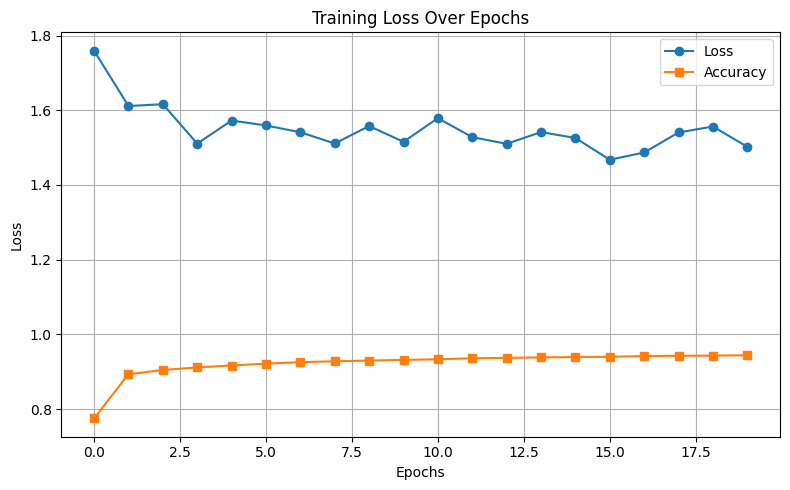

In [13]:
key= random.PRNGKey(42)
L=[784,128,64,10]
epochs=20
batch_size=32
params, history = MLP_Training(params=init_params(key, len(L) , L), 
                               x_train=x_train, y_train=y_train_oh, 
                               x_test=x_test, y_test=y_test_oh, 
                               epochs=20, batch_size=32, lr=learning_rate)
print("History length:", len(history))
print("Accuracy of the model:", accuracy(params, x_test, y_test_oh))
plot_loss_accuracy(history)

## B) Training Multi Layer Perceptron using TensorFlow

### Importing necessary libraries & initializing data

In [16]:
import jax.numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Load MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize
x_train = x_train / 255.0
x_test = x_test / 255.0

### Defining & Training Sequential Model

In [34]:
model = Sequential([
    Flatten(input_shape=(28, 28)),           # Input layer
    Dense(128, activation='relu'),        # Hidden layer
    Dense(24, activation='sigmoid'),         # Hidden layer
    Dropout(0.1),                         #Dropout
    Dense(10, activation='softmax')          # Output layer
])

# Compile
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()

# Show model config
print(model.get_config())
history = model.fit(x_train, y_train,validation_data=(x_test, y_test),epochs=10,batch_size=32)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 24)             │         3,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 10)             │           250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,826 (405.57 KB)

 Trainable params: 103,826 (405.57 KB)

 Non-trainable params: 0 (0.00 B)

{'name': 'sequential_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 28, 28), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_layer_10'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': (None, 28, 28)}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_30', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'modul

### Evaluating Model

In [39]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Test Accuracy: 0.9787, Test Loss: 0.0789


### Plotting Graph

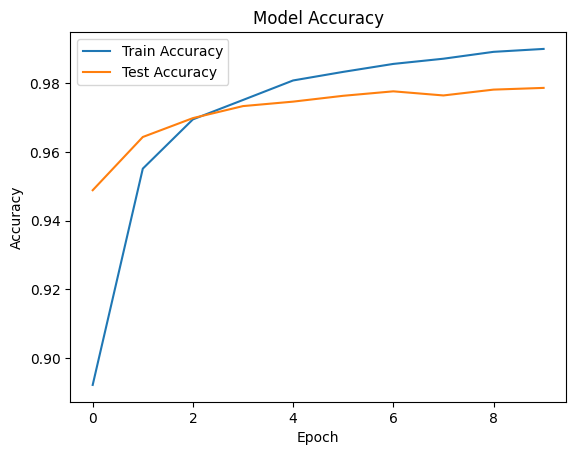

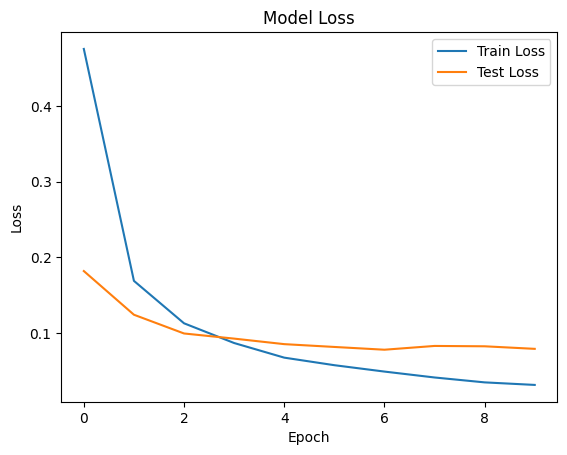

In [35]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Making Prediction

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step


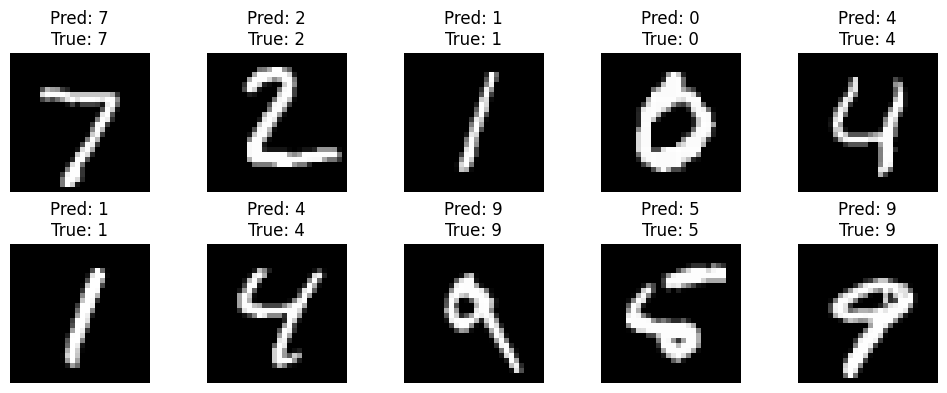

In [36]:
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

# Show first 10 test images and predictions
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"Pred: {predicted_labels[i]}\nTrue: {y_test[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
